In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
    os.chdir(os.path.join(os.getcwd(), '..'))
except:
    pass

 # Detection of rice grains using ellipses

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from multiprocessing import Pool
from pybalu.feature_extraction.geometric_utils import bbox as _bbox
from pybalu.feature_extraction import basic_geo_features
from pybalu.io import imread
from skimage.measure import label


 ## Matplotlib setup
 The following code is used to set up the default parameters for all the
 plots shown by matplotlib

In [2]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (7, 7)
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["axes.titlepad"] = 15
matplotlib.rcParams["figure.figsize"] = (7, 7)
del matplotlib

 ## Loading and displaying the image

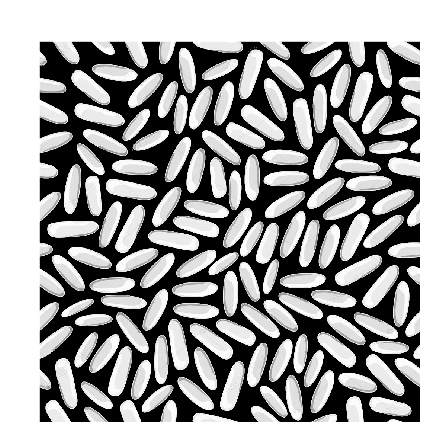

In [3]:
im = imread("feature_extraction/rice.png")
plt.title("Original Image", fontdict={"fontsize": 20}, pad=20)
plt.imshow(im, cmap="gray")
plt.show()

 ## Recognizing rice grains
 In order to recognize the grains, the following steps are followed:

   1. Image is transformed to binary
   2. Rice grains are separated and labeled accordingly
   3. Geometric features are calculated for each grain by using `basic_geo_features` function
   4. An `Ellipse` object is built for each grain

In [4]:
im_bin = (im > 140).astype(int)
labeled, n = label(im_bin, return_num=True)
labeled_T = labeled.T


def calc_ellipse(idx):
    region = (labeled_T == idx).astype(int)
    box = _bbox(region)
    feats = basic_geo_features(region[box])
    return np.array([
        box[0].start + feats[0],    # feats[0]:  center of grav i [px]
        box[1].start + feats[1],    # feats[1]:  center of grav j [px]
        feats[10],                  # feats[10]: MajorAxisLength  [px]
        feats[11],                  # feats[11]: MinorAxisLength  [px]
        feats[12]                   # feats[12]: Orientation      [deg]
    ])


with Pool() as pool:
    ellipses = np.vstack(pool.map(calc_ellipse, range(1, n)))

 ## Displaying the ellipses over the original image

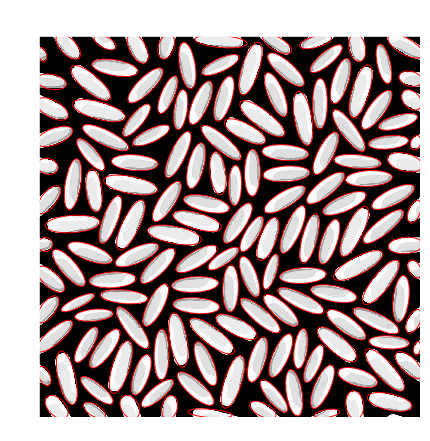

In [5]:
ax = plt.axes()
plt.title("Segmented Image")
plt.imshow(im, cmap="gray")


def draw_ellipse(x, y, height, width, angle, axes):
    ell = Ellipse(xy=(x, y), height=height, width=width,
                  angle=angle, edgecolor="red", facecolor="none")
    axes.add_artist(ell)
    ell.set_clip_box(axes.bbox)
    return ell


for ell in ellipses:
    draw_ellipse(*ell, axes=ax)

plt.show()

 ## Finding mean sized (major axis) rice grains
 Rice grains whose major axis is between the 25th and 75th percentile are highlighted.
 This is done with the help numpy matrix operations

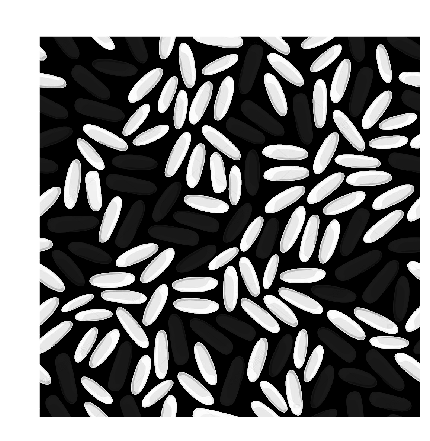

In [6]:
plt.title("Mean sized rice grains (major axis)")

major_25 = np.percentile(ellipses[:, 3], 25)
major_75 = np.percentile(ellipses[:, 3], 75)

valid_labels = 1 + \
    np.where((ellipses[:, 3] > major_25) & (ellipses[:, 3] < major_75))[0]
im_mean = np.array(im)
im_mean[np.where(~np.isin(labeled, valid_labels))] //= 7
plt.imshow(im_mean, cmap="gray")
plt.show()

 ## Finding rice grains oriented at a specific angle
 Rice grains rotation is within 10deg of the given angle are highlighted. Just as
 before, this is done with the help of numpy matrix operations

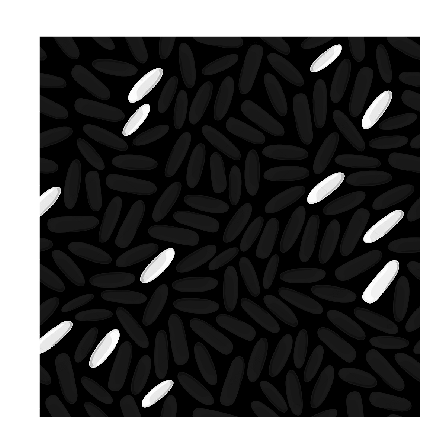

In [7]:
def draw_at_angle(theta):
    valid_labels = 1 + \
        np.where((ellipses[:, 4] > theta - 10) &
                 (ellipses[:, 4] < theta + 10))[0]
    plt.title(f"Orientation at {theta} deg")
    im_rotated = np.array(im)
    im_rotated[np.where(~np.isin(labeled, valid_labels))] //= 7
    plt.imshow(im_rotated, cmap="gray")
    plt.show()


draw_at_angle(45)